# Semana 5: Notebook de Procesamiento de Imágenes

**Clase:** CDSI 2026  
**Profesor:** Irvin Hussein López Nava  
**Alumno:** Javier R  

----

## Descripción

Este notebook tiene como objetivo explorar distintas librerías de Python orientadas al procesamiento digital de imágenes, así como aplicar técnicas fundamentales y complementarias para el análisis y transformación de datos visuales.

Se usan diferentes tipos de entradas:
- Arreglos numéricos
- Imágenes obtenidas de internet
- Fotografías

----


In [19]:
import os

# Path base
BASE_PATH = os.getcwd()

# Carpeta images
IMAGES_PATH = os.path.join(BASE_PATH, "images")

print("BASE_PATH:", BASE_PATH)
print("IMAGES_PATH:", IMAGES_PATH)


BASE_PATH: /content
IMAGES_PATH: /content/images


# Recolección de datos

Se descargan varias imágenes y se guardan localmente en la carpeta `images`.


In [20]:
!mkdir -p images

!wget -q -O images/isagi.jpg https://i.pinimg.com/736x/1f/25/b8/1f25b8a2bf63b6a0c6639aeeac4bfdbe.jpg
!wget -q -O images/tiburon.jpg https://www.tiendanimal.es/articulos/wp-content/uploads/2021/06/tiburon-blanco-animales-marinos-mas-grandes-del-mundo-scaled.jpg
!wget -q -O images/black_hole.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Black_hole_-_Messier_87_crop_max_res.jpg/330px-Black_hole_-_Messier_87_crop_max_res.jpg
!wget -q -O images/cr7.jpg https://www.shutterstock.com/image-photo/leipzig-germany-june-18-2024-600nw-2480563319.jpg


# Imágenes

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path


In [22]:
image_paths = [
    os.path.join(IMAGES_PATH, "isagi.jpg"),
    os.path.join(IMAGES_PATH, "tiburon.jpg"),
    os.path.join(IMAGES_PATH, "black_hole.jpg"),
    os.path.join(IMAGES_PATH, "cr7.jpg")
]

### Imágenes originales

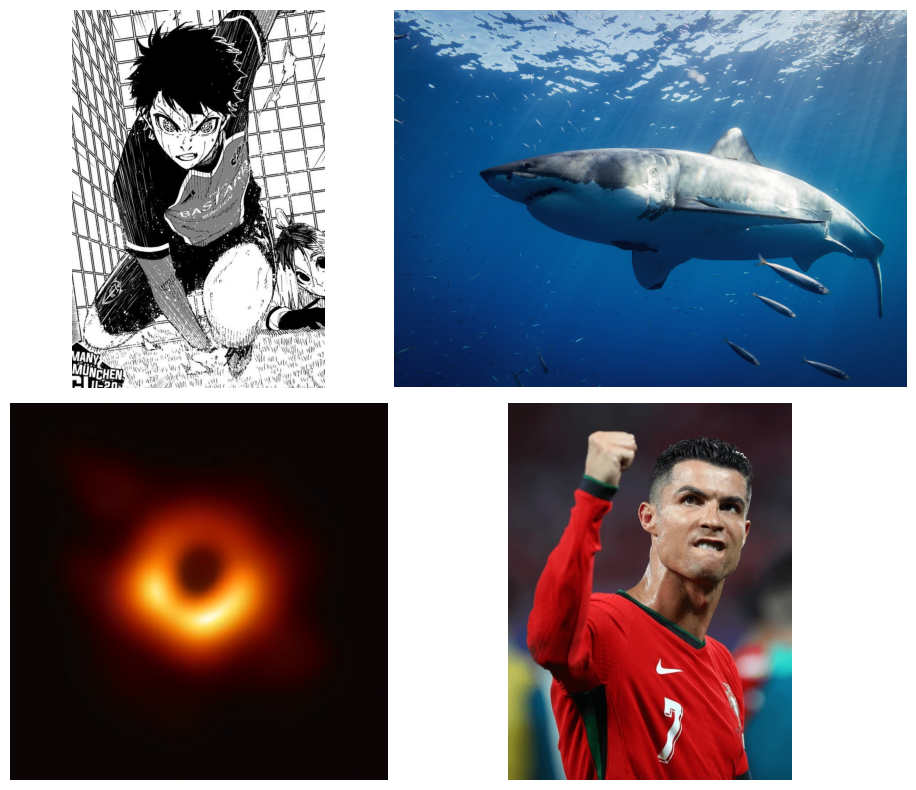

In [24]:
plt.figure(figsize=(10, 8))

for i, path in enumerate(image_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Arreglo sintético (NumPy)

Se genera un arreglo 2D de valores aleatorios con NumPy y se visualiza como una imagen en escala de grises.


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

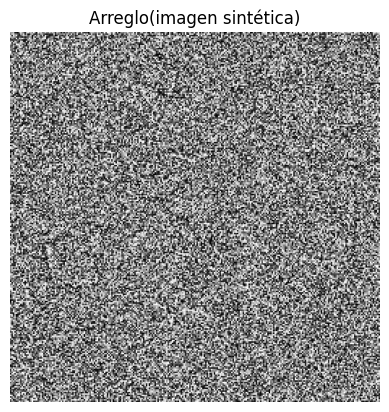

In [25]:
import numpy as np
import matplotlib.pyplot as plt

arr = np.random.rand(256, 256)

plt.imshow(arr, cmap="gray")
plt.title("Arreglo(imagen sintética)")
plt.axis("off")

### Arreglo NumPy + FFT (diferentes escalas)

`arr` es una imagen sintética: una matriz 256×256 con valores aleatorios uniformes en el rango (0, 1).

Se calcula su Transformada de Fourier 2D, que convierte la imagen del dominio espacial al dominio de frecuencias.  
`fftshift` centra las bajas frecuencias en la imagen resultante.

`mag` es la magnitud del espectro de frecuencias.  
Se usa `log(|FFT| + 1)` para comprimir el rango dinámico y hacer visibles tanto frecuencias bajas como altas.

Las potencias (`mag ** 0.5`, `mag ** 1`, `mag ** 2`) cambian el contraste del espectro, enfatizando distintas bandas de frecuencia.


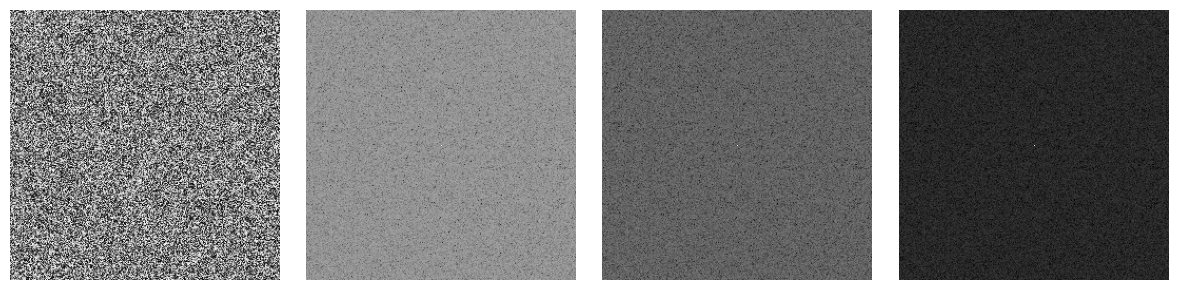

In [ ]:
arr = np.random.rand(256, 256)

fft = np.fft.fftshift(np.fft.fft2(arr))
mag = np.log(np.abs(fft) + 1)

plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.imshow(arr, cmap="gray")
plt.axis("off")

for i, scale in enumerate([0.5, 1, 2]):
    plt.subplot(1, 4, i + 2)
    plt.imshow(mag ** scale, cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Filtro en frecuencia (Low-pass)

La imagen se convierte a escala de grises y se transforma al dominio de frecuencias usando la FFT 2D.

Se crean máscaras cuadradas centradas en el espectro que conservan solo frecuencias bajas dentro de distintos rangos (±r).  
Cada máscara elimina las altas frecuencias.

Luego se aplica la transformada inversa para reconstruir la imagen filtrada.  
A mayor rango, se conservan más detalles; a menor rango, la imagen se vuelve más suave y borrosa.


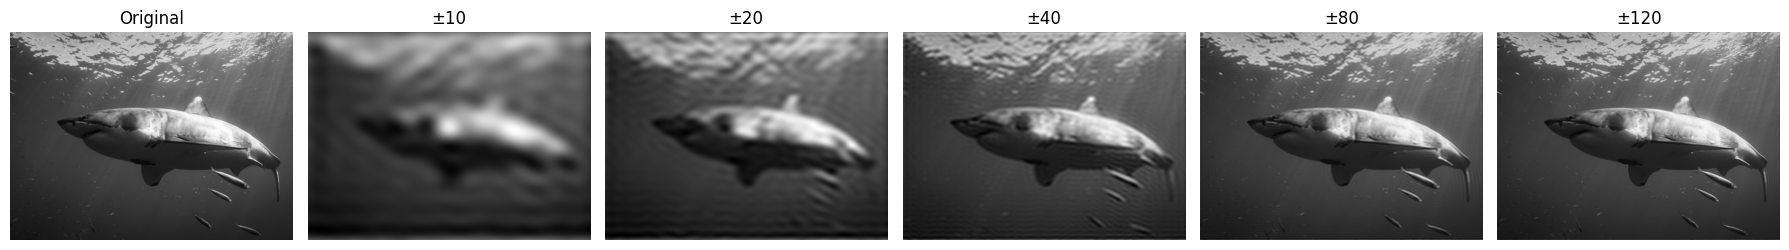

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("images/tiburon.jpg", cv2.IMREAD_GRAYSCALE)

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

intervals = [10, 20, 40, 80, 120]

fig, axes = plt.subplots(1, len(intervals) + 1, figsize=(18, 4))

axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

for ax, r in zip(axes[1:], intervals):
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-r:crow+r, ccol-r:ccol+r] = 1

    fshift_filtered = fshift * mask
    img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift_filtered)))

    ax.imshow(img_back, cmap="gray")
    ax.set_title(f"±{r}")
    ax.axis("off")

plt.tight_layout()
plt.show()


### CLAHE (variando clipLimit)

Se aplica ecualización adaptativa de histograma (CLAHE) a la imagen en escala de grises.

El parámetro `clipLimit` controla cuánto se incrementa el contraste local: valores bajos producen cambios suaves, valores altos generan mayor contraste y pueden amplificar ruido.


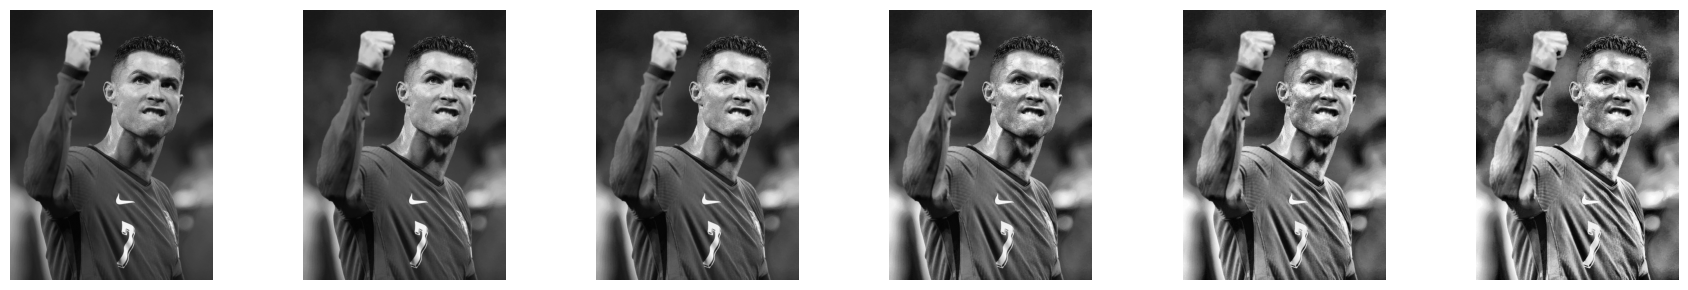

In [27]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("images/cr7.jpg", cv2.IMREAD_GRAYSCALE)

clip_limits = [0.5, 1.0, 2.0, 4.0, 8.0]

plt.figure(figsize=(18, 3))
plt.subplot(1, len(clip_limits) + 1, 1)
plt.imshow(img, cmap="gray")
plt.axis("off")

for i, cl in enumerate(clip_limits):
    clahe = cv2.createCLAHE(clipLimit=cl, tileGridSize=(8, 8))
    out = clahe.apply(img)

    plt.subplot(1, len(clip_limits) + 1, i + 2)
    plt.imshow(out, cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Morfología (tamaño del kernel)

Se aplica la operación morfológica de apertura a la imagen en escala de grises.

La apertura (erosión seguida de dilatación) elimina detalles pequeños y ruido.  
Al aumentar el tamaño del kernel, se eliminan estructuras cada vez más grandes y la imagen se vuelve más suave.


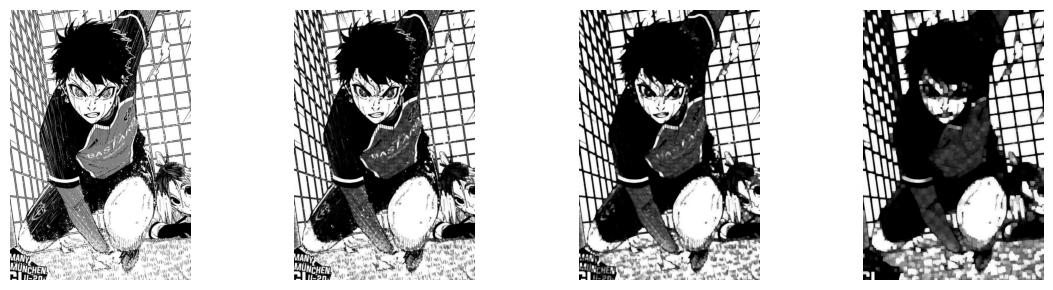

In [ ]:
img = cv2.imread("images/isagi.jpg", cv2.IMREAD_GRAYSCALE)

kernel_sizes = [3, 5, 9]

plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray")
plt.axis("off")

for i, k in enumerate(kernel_sizes):
    kernel = np.ones((k, k), np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    plt.subplot(1, 4, i + 2)
    plt.imshow(opening, cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()


La morfología matemática permite analizar la estructura del agujero negro a diferentes escalas, destacando el borde del horizonte de eventos, el halo luminoso y las regiones de alta absorción mediante operaciones no lineales basadas en forma.

El gradiente resalta bordes, el *top-hat* extrae detalles claros pequeños, el *black-hat* resalta detalles oscuros, la apertura elimina ruido pequeño y el cierre rellena huecos y conecta regiones cercanas.




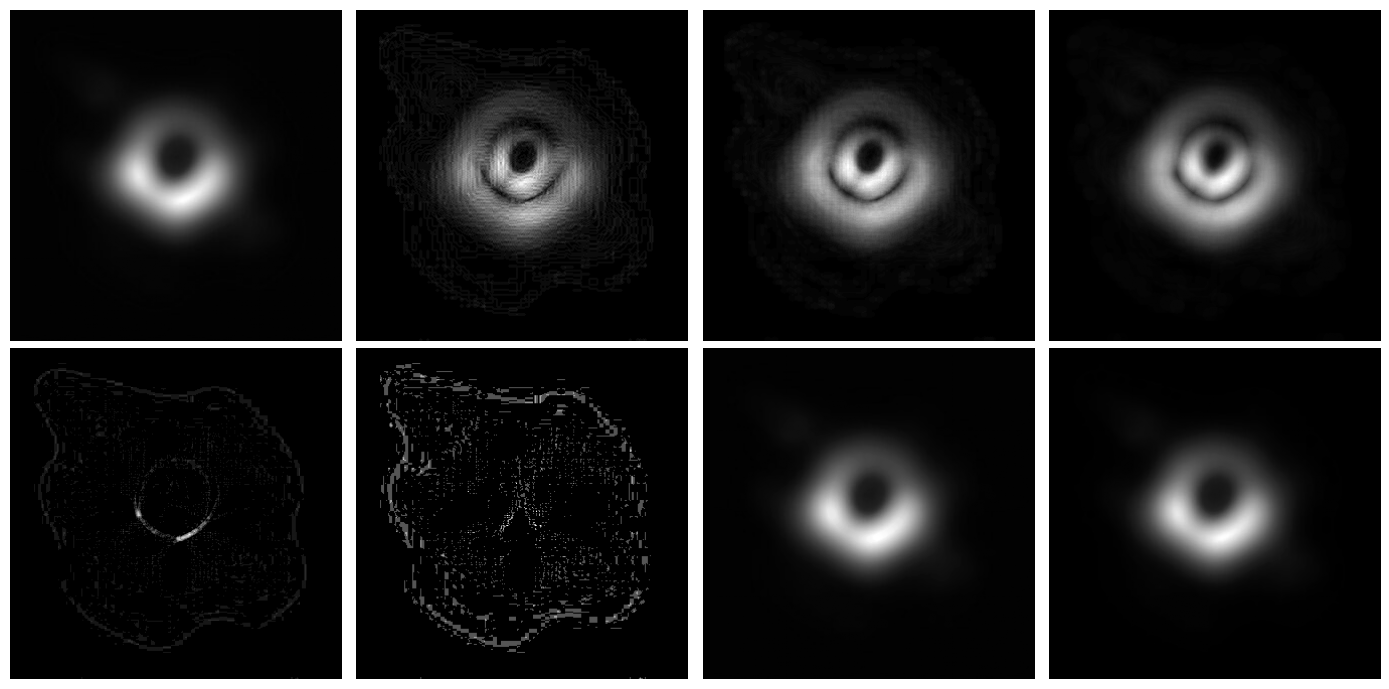

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("images/black_hole.jpg", cv2.IMREAD_GRAYSCALE)

kernels = {
    "small": cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)),
    "medium": cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)),
    "large": cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
}

results = [
    img,
    cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernels["small"]),
    cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernels["medium"]),
    cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernels["large"]),
    cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernels["medium"]),
    cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernels["medium"]),
    cv2.morphologyEx(img, cv2.MORPH_OPEN, kernels["medium"]),
    cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernels["medium"]),
]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))

for ax, res in zip(axes.flat, results):
    ax.imshow(res, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()


### HISTOGRAMAS

Se aplican múltiples transformaciones de intensidad y filtrado

Se comparan métodos de mejora de contraste (ecualización global, CLAHE, corrección gamma), suavizado y realce de bordes, normalización y negado.  
Para cada resultado se muestra la imagen y su histograma, para ver cómo cada operación redistribuye los niveles de intensidad.


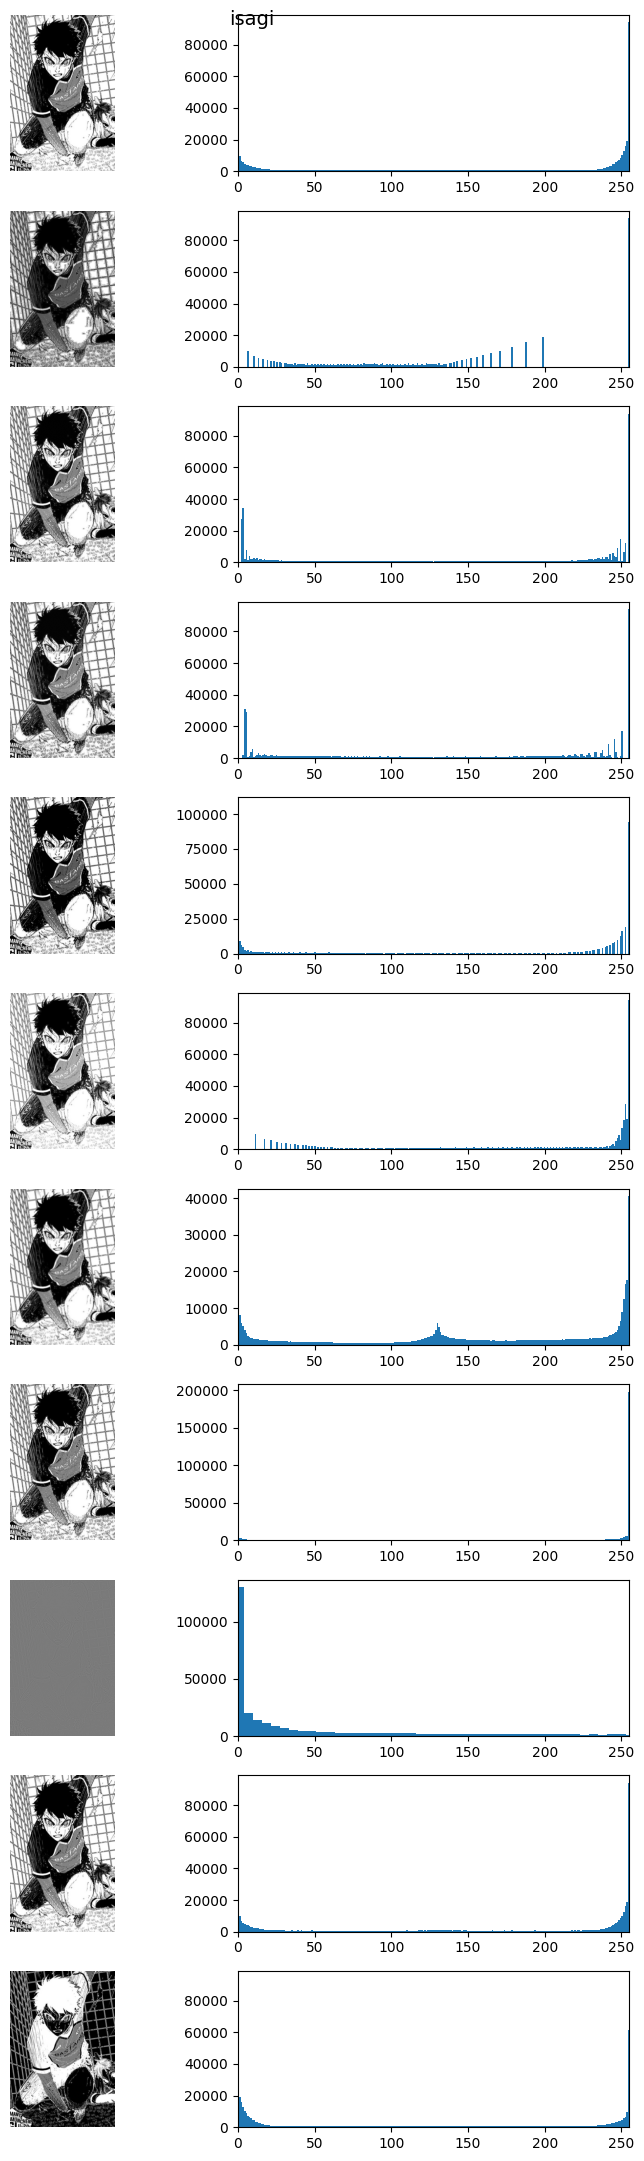

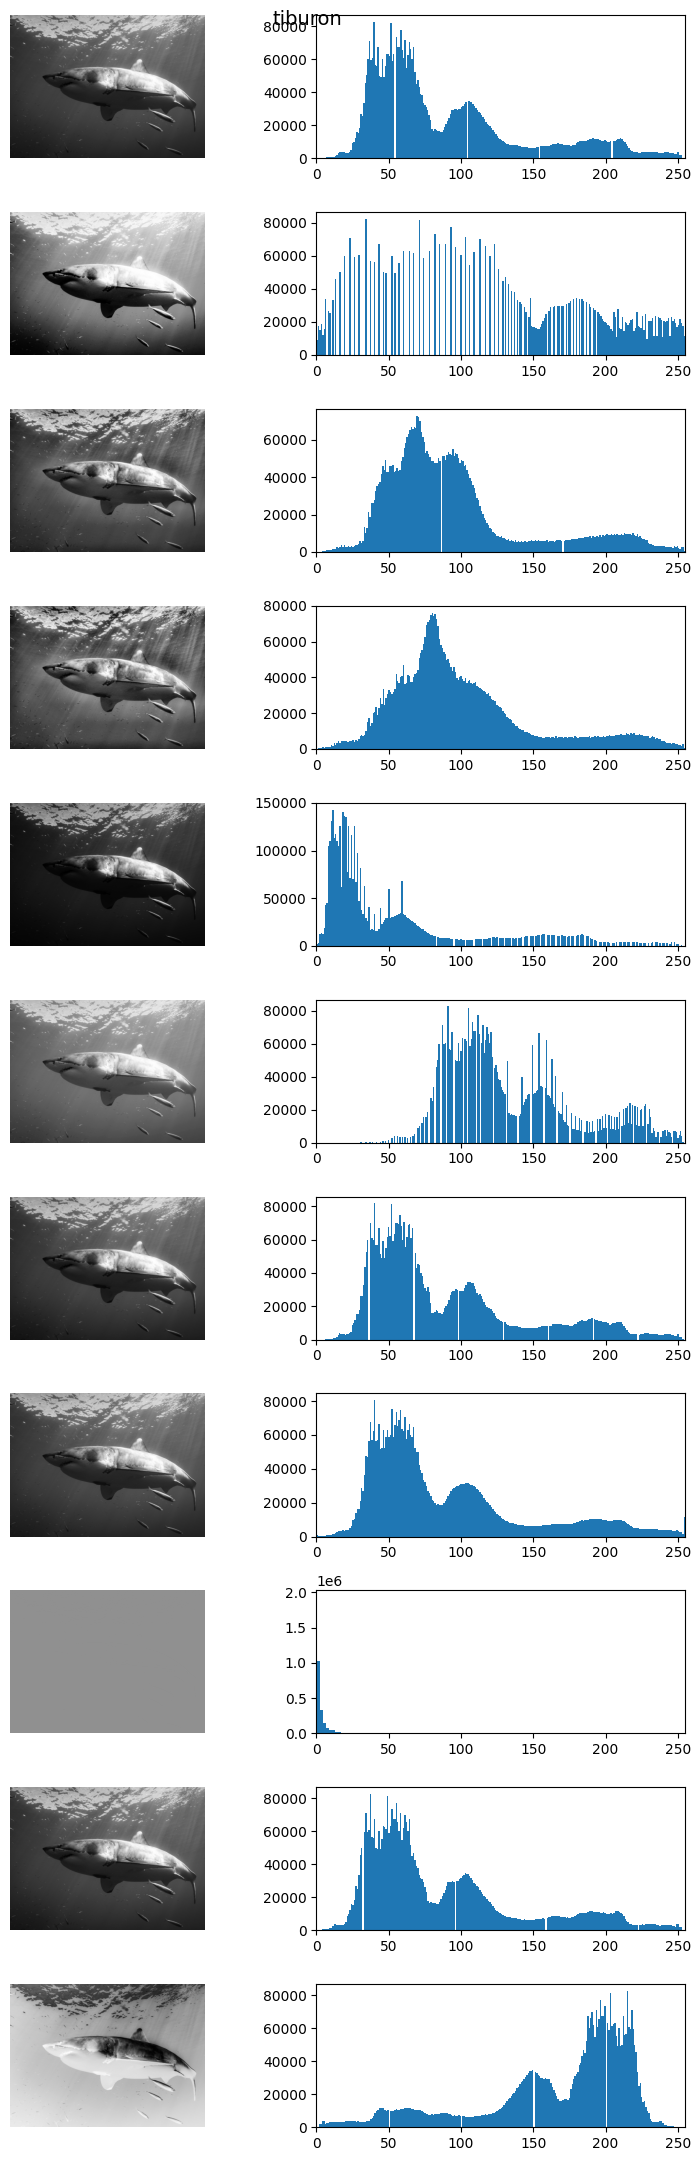

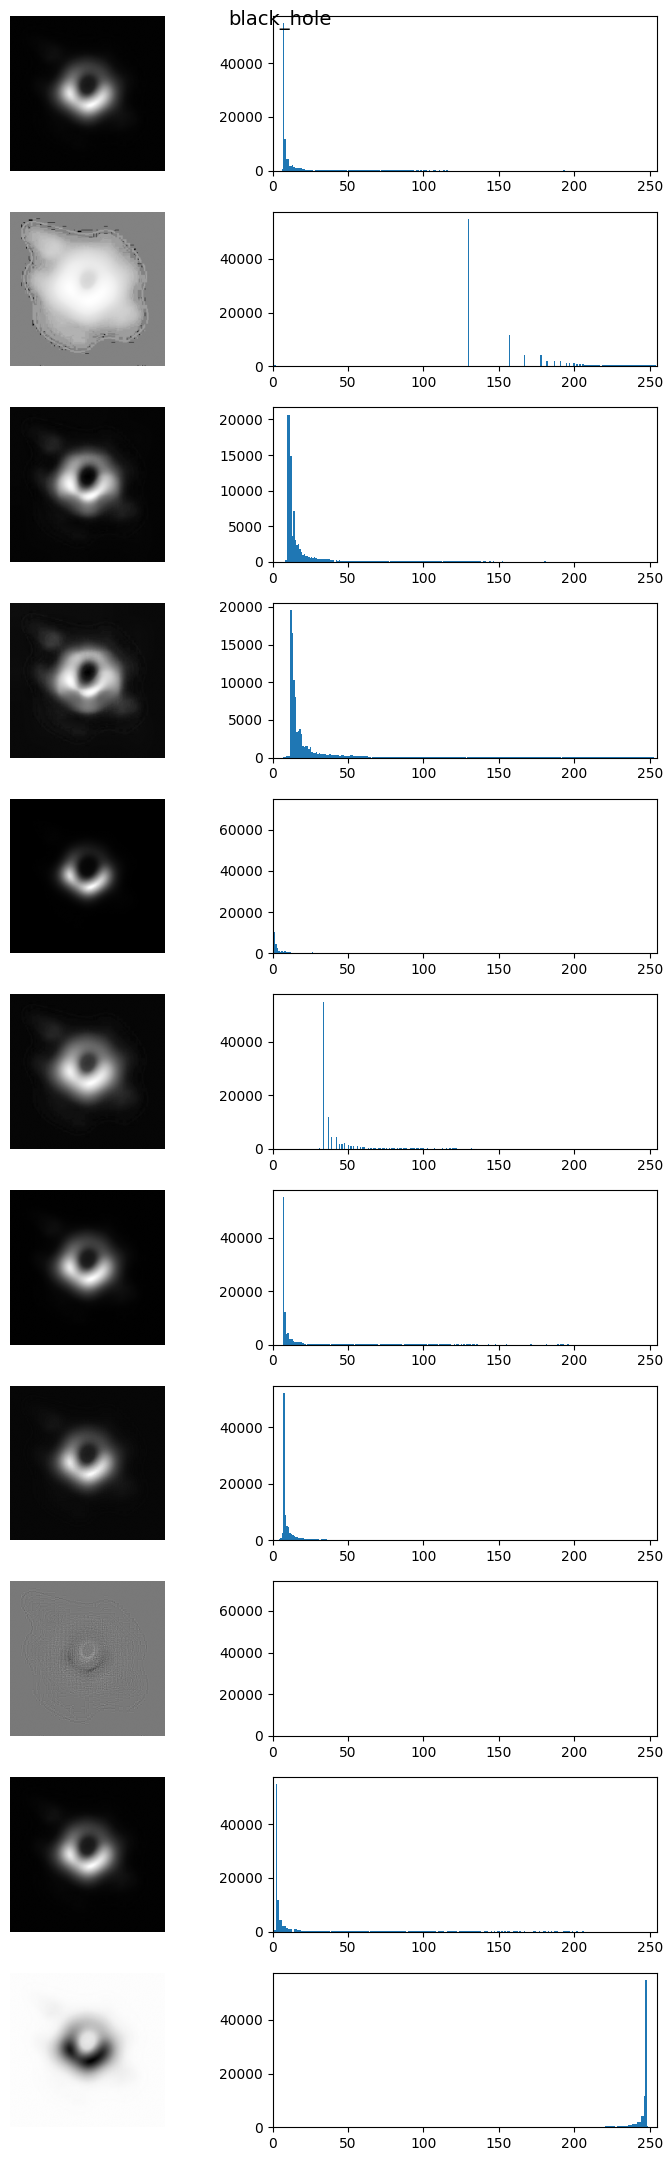

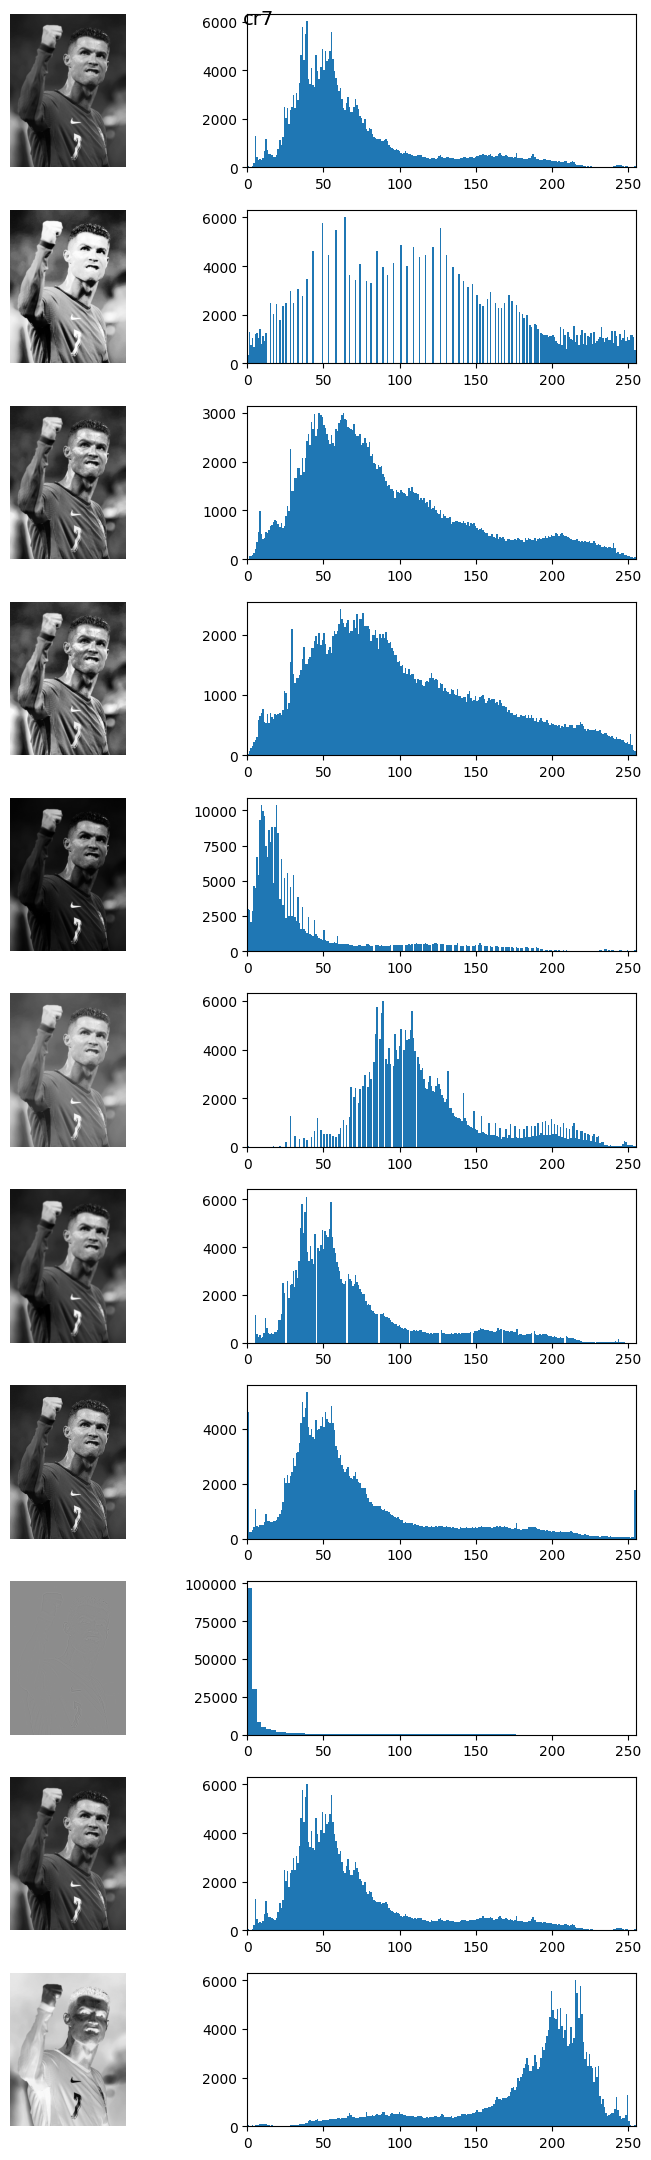

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def gamma_correction(img, gamma):
    inv = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)

images = {
    "isagi": "images/isagi.jpg",
    "tiburon": "images/tiburon.jpg",
    "black_hole": "images/black_hole.jpg",
    "cr7": "images/cr7.jpg"
}

for name, path in images.items():
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    variations = [
        img,
        cv2.equalizeHist(img),
        cv2.createCLAHE(2.0, (8,8)).apply(img),
        cv2.createCLAHE(4.0, (8,8)).apply(img),
        gamma_correction(img, 0.6),
        gamma_correction(img, 1.8),
        cv2.GaussianBlur(img, (7,7), 0),
        cv2.filter2D(img, -1, np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])),
        cv2.Laplacian(img, cv2.CV_64F),
        cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX),
        255 - img
    ]

    fig, axes = plt.subplots(len(variations), 2, figsize=(8, 22))
    fig.suptitle(name, fontsize=14)

    for i, v in enumerate(variations):
        axes[i, 0].imshow(v, cmap="gray")
        axes[i, 0].axis("off")

        axes[i, 1].hist(v.ravel(), bins=256)
        axes[i, 1].set_xlim(0, 255)

    plt.tight_layout()
    plt.show()


### Métricas cuantitativas

Se evaluaron distintas transformaciones de procesamiento digital de imágenes utilizando métricas cuantitativas como entropía, desviación estándar y media de intensidad. Los resultados muestran que cada técnica modifica de forma distinta la distribución de información, lo cual concuerda con los cambios observados visualmente.

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy
import pandas as pd

def metrics(img):
    return {
        "Entropy": shannon_entropy(img),
        "Std": np.std(img),
        "Mean": np.mean(img)
    }

def gamma_correction(img, gamma):
    inv = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)


In [40]:
def get_variations(img):
    return {
        "Original": img,
        "Equalized": cv2.equalizeHist(img),
        "CLAHE_2": cv2.createCLAHE(2.0, (8,8)).apply(img),
        "CLAHE_4": cv2.createCLAHE(4.0, (8,8)).apply(img),
        "Gamma_0.6": gamma_correction(img, 0.6),
        "Gamma_1.8": gamma_correction(img, 1.8),
        "GaussianBlur": cv2.GaussianBlur(img, (7,7), 0),
        "Sharpen": cv2.filter2D(img, -1, np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])),
        "Laplacian": cv2.Laplacian(img, cv2.CV_64F)
    }


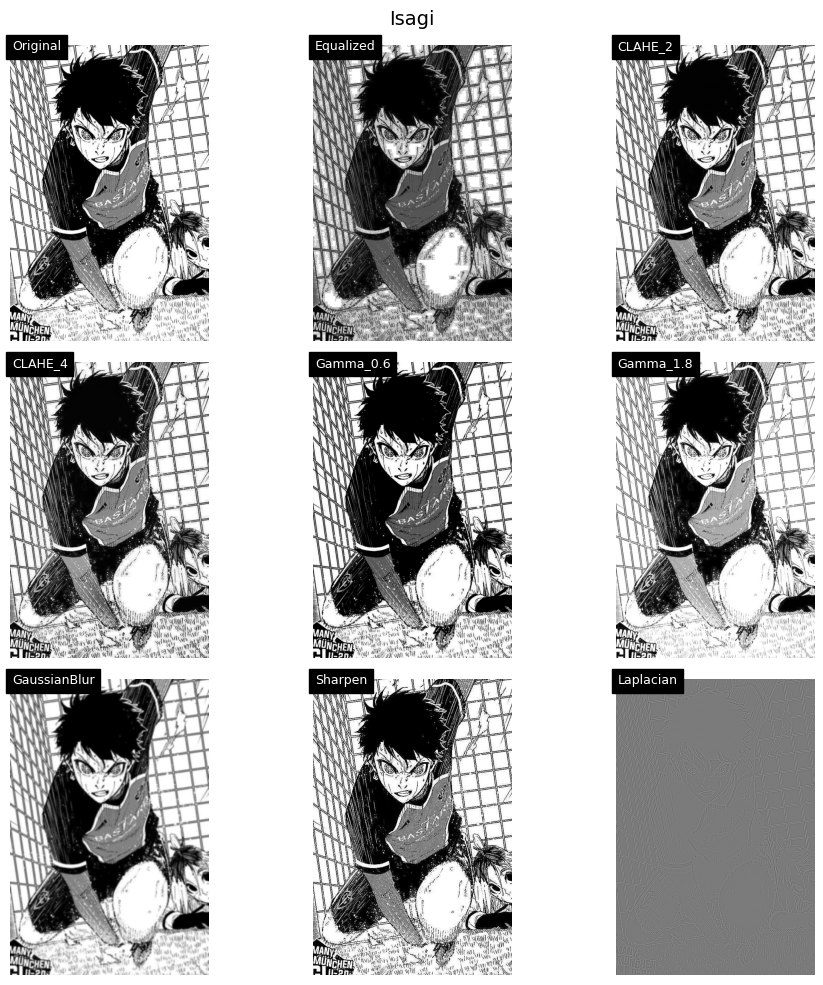

Entropy         Std        Mean
Technique                                     
Original      6.126496  106.337348  149.126930
Equalized     5.728532   88.635203  117.787802
CLAHE_2       6.484716  101.025317  148.120709
CLAHE_4       6.539219   97.263457  145.996175
Gamma_0.6     5.460148  110.452019  135.625635
Gamma_1.8     5.809201   99.394891  165.248439
GaussianBlur  7.102333   92.647924  149.127639
Sharpen       3.795994  117.475532  147.809020
Laplacian     7.842125  126.253800   -0.005878

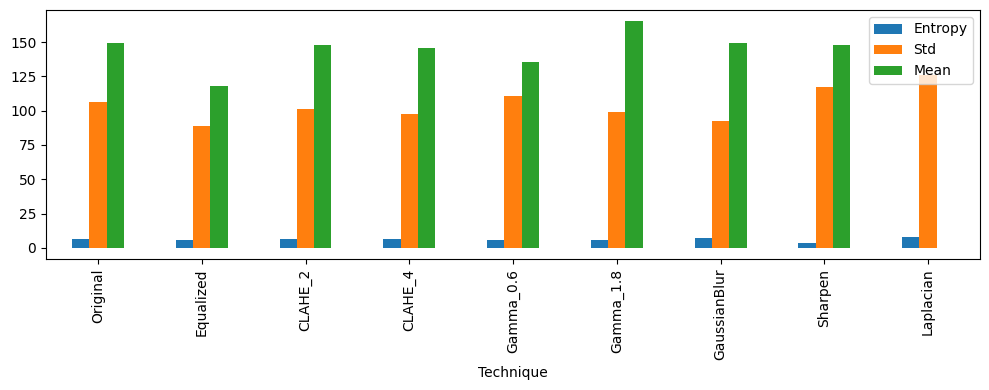

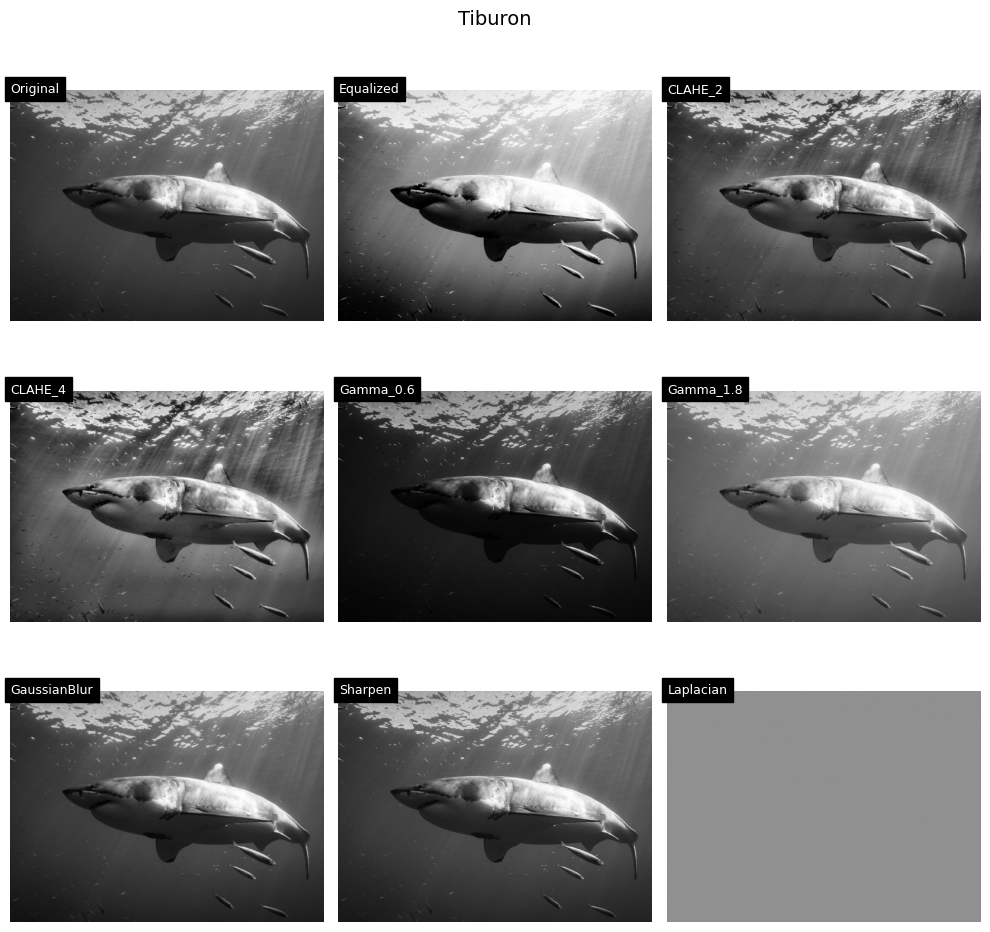

Entropy        Std        Mean
Technique                                    
Original      7.304637  53.036207   89.271449
Equalized     7.014556  73.172566  128.528404
CLAHE_2       7.247463  48.985603   94.634565
CLAHE_4       7.371108  48.462192  100.272571
Gamma_0.6     6.771147  53.089902   52.138692
Gamma_1.8     7.087197  44.083655  136.337877
GaussianBlur  7.303352  52.688526   89.273579
Sharpen       7.333593  54.072489   89.228796
Laplacian     3.890116   7.341973    0.000055

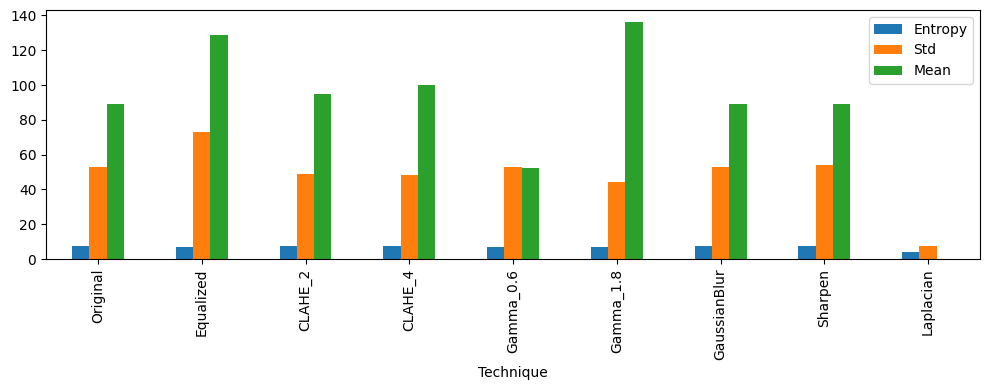

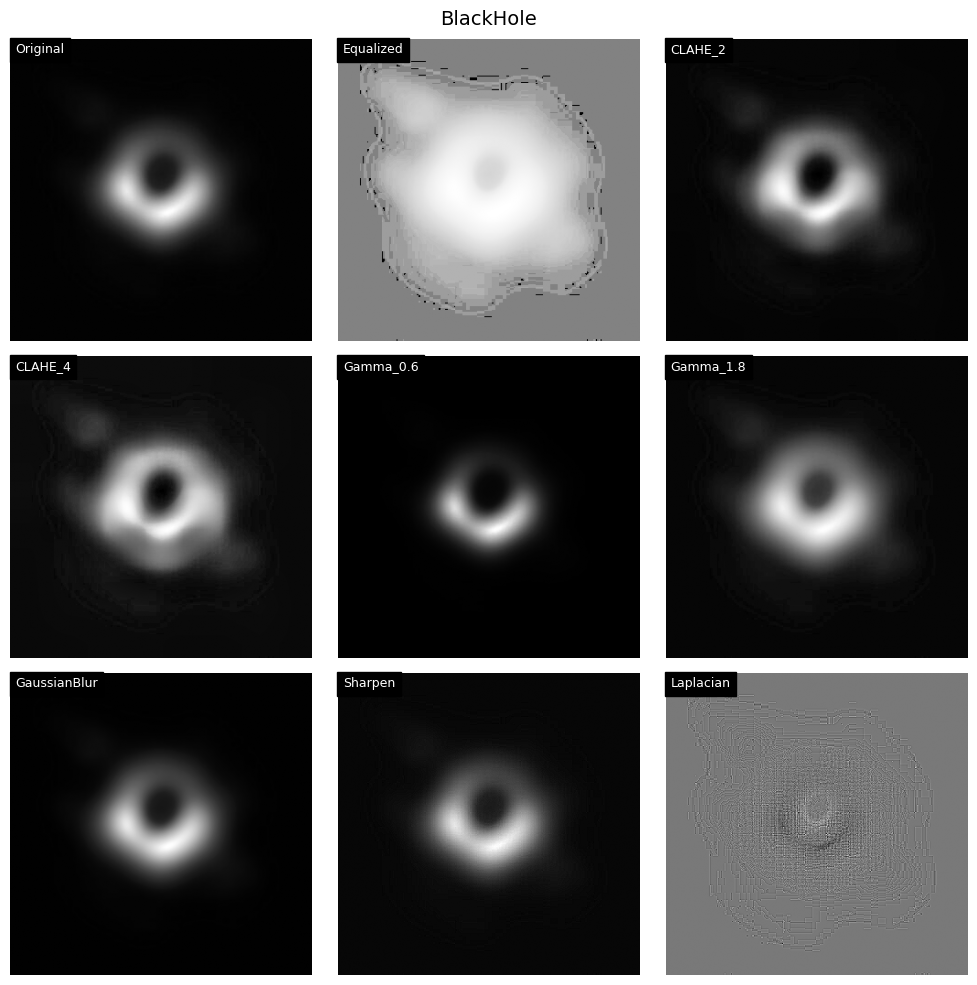

Entropy        Std        Mean
Technique                                    
Original      3.804189  37.980184   22.155464
Equalized     3.480598  41.399642  162.138577
CLAHE_2       4.854654  44.728842   31.145069
CLAHE_4       5.292378  49.419445   37.953719
Gamma_0.6     2.704494  30.077470    9.192672
Gamma_1.8     3.767087  41.657370   54.277282
GaussianBlur  3.768720  37.898424   22.154729
Sharpen       4.029444  38.088882   22.155546
Laplacian     1.813953   1.078243    0.000000

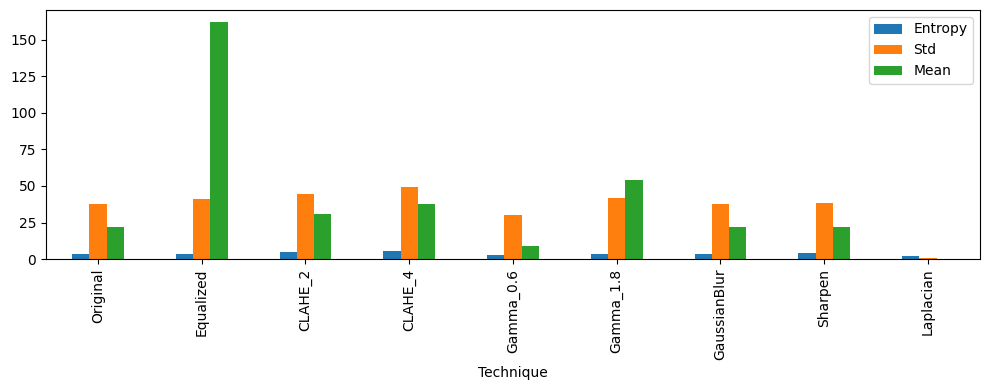

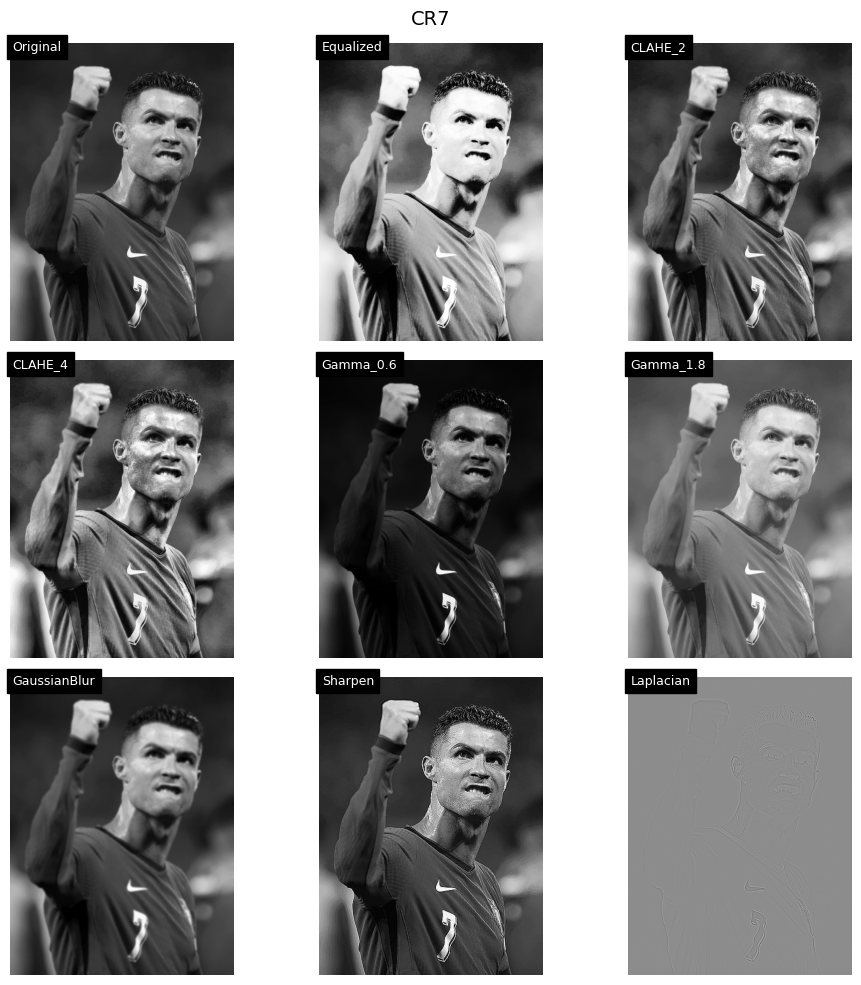

Entropy        Std        Mean
Technique                                    
Original      7.098228  46.792955   70.751367
Equalized     6.793501  73.156848  128.766796
CLAHE_2       7.553327  53.948179   90.164944
CLAHE_4       7.742170  57.879904  101.870493
Gamma_0.6     6.350243  43.015391   36.455267
Gamma_1.8     6.963275  42.207743  118.820433
GaussianBlur  7.063231  45.510352   70.750607
Sharpen       7.171516  50.806736   70.941348
Laplacian     4.882587  19.993590   -0.000126

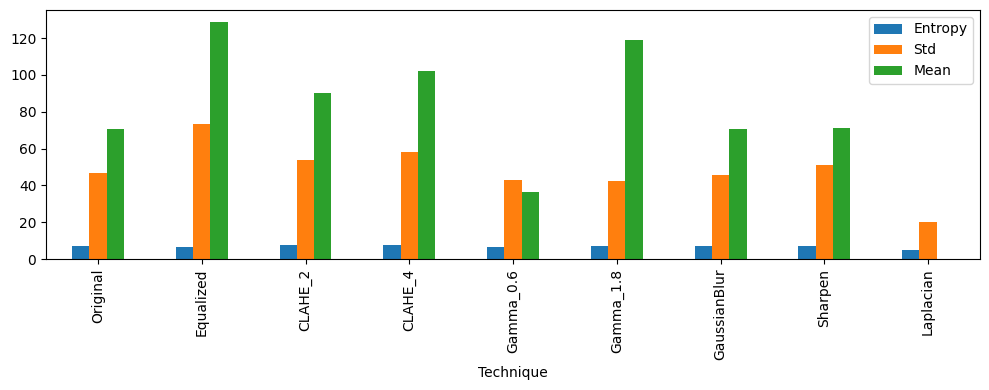

In [41]:
images = {
    "Isagi": "images/isagi.jpg",
    "Tiburon": "images/tiburon.jpg",
    "BlackHole": "images/black_hole.jpg",
    "CR7": "images/cr7.jpg"
}

for name, path in images.items():
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    variations = get_variations(img)

    # ---- FIGURA DE IMÁGENES ----
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()

    for ax, (label, v) in zip(axes, variations.items()):
        ax.imshow(v, cmap="gray")
        ax.axis("off")
        ax.text(5, 15, label, color="white", fontsize=9, backgroundcolor="black")

    plt.suptitle(name, fontsize=14)
    plt.tight_layout()
    plt.show()

    # ---- MÉTRICAS COMO TABLA ----
    data = []
    for label, v in variations.items():
        m = metrics(v)
        m["Technique"] = label
        data.append(m)

    df = pd.DataFrame(data).set_index("Technique")

    display(df)

    # ---- MÉTRICAS VISUALES ----
    df.plot(kind="bar", figsize=(10, 4))
    plt.tight_layout()
    plt.show()
